Import necessary libraries 

In [43]:
import statistics
import numpy as np
from numpy import inf
from matplotlib import pyplot as plt
import scipy
import math

Create the bernoulli probability distribution function - coin flips are bernoullis

In [44]:
def bernoulli_pdf(p, y):
    if y: 
        return (p)
    else: 
        return (1 - p)

Calculating the likelihood of a switch at all the possible positions in the data. Sum of the likelihoods will be used to normalise the data in the PosteriorTs function. 

In [45]:
def l_switch(data, p1, p2):
    likelihoods = np.zeros(len(data))
    for i in range(0, len(likelihoods)-1):
        likelihoods[i] = np.prod([bernoulli_pdf(p1, x) for x in data[0:(i)]]) * np.prod([bernoulli_pdf(p2, x) for x in data[i+1:]])
    return likelihoods, sum(likelihoods)

If we attempt to normalise the likelihoods by dividing by zero, this will result in a NaN error. 

Furthermore, if the likelihoods sum to zero, this means every likelihood within the ls array is zero. There is no point sampling from an array with zero likelihoods for each element - we just return zero. 

pt is the normalised list of probabilities for the coin swap t. We normalise so that the probabilities add up to one. 

random.choice allows us to choose a position from data for a switch to be located at - this choice will be dictated by the weights in pt, the normalised list of probabilities. 

In [46]:
def tSample(data, p1, p2):
    ls, suml = l_switch(data, p1, p2)
    if suml == 0.0:
        return 0, 0
    pt = ls / suml

    return pt, np.random.choice(np.arange(len(data)), p=pt)

finding the likelihood of a bias for a given coin

log the probabilities to prevent numerical underflow

use xlogy(x, y) to deal with the boundary case 0*log(0) case gracefully

In [53]:
def l_bias(bias, data):
    N = len(data)
    N_positive = sum(data)
    logL = scipy.special.xlogy(N_positive, bias) + scipy.special.xlogy((N-N_positive), (1-bias))
    return logL

likelihoods is a list of biases that p1 could take on. 

logsum is used to normalise likelihoods. 

posterior_dis is 

In [55]:
def pSample(data, biases):
    likelihoods = [l_bias(bias, data) for bias in biases]
    logsum = scipy.special.logsumexp(likelihoods[0]) # likelihoods is a 2d array - accessing the data with [0]
    normalised_weights = [math.exp(x - logsum) for x in likelihoods[0]]

    return normalised_weights, np.random.choice(biases[0], p=normalised_weights)

Importing the data from the file

In [50]:
data = []
with open('q3_data.txt', 'r') as file:
    data = [line.rstrip() for line in file] # getting rid of newline chars 
data = list(data)


Main Gibbs Sampling function 

In [65]:
def GibbsSampler(data):

    # Calculate the size of the dataset
    DL = len(data)

    # Calculate the burn in size - half the data length is a nice balance between 
    # accuracy, and time to run
    burnin = int(DL / 2)

    # Take a guess at where the switches might be - since 
    # there are two, we can guess that the data will be split 
    # into three equal parts
    t0 = int(DL/3)
    t1 = int((DL/3) * 2)
    print("Initial guess at t0 = ", t0)
    print("Initial guess at t1 = ", t1)
    
    # Replace missing data points with randomly chosen ones and zeros - 
    # this is just to facilitate an initial guess
    temp_data = [x.replace("NA", str(np.random.randint(2))) for x in data ]
    
    # Convert the list of strings to a list of integers
    temp_data = list(map(int,temp_data))
    
    
    # Take a guess at the weighting of the coins based on 
    # the mean of the values in the appropriate areas
    p1 = round(statistics.mean(temp_data[0:t0] + temp_data[t1:]), 2)
    print("Initial guess at p1 = ", p1)
    p2 = round(statistics.mean(temp_data[t0:t1]), 2)
    print("Initial guess at p2 = ", p2)
    
    # Visual divider
    print("\n-------------------------------------------------\n")
    
    # Generate a list of weightings the coins could be, 
    # accurate to two decimal places
    probabilities = np.arange(0.0, 1.01, 0.01), 1
    
    # Create an array to store the results of t0, t1, p1, p2
    samples = np.zeros(((DL*10)-1, 4))

    # Iteratively 'guess' results 'i' times 
    for i in range(0, DL*10+burnin):
        
        # Take a copy of data to replace NA or missing values
        i_data = data
        
        # Replace the missing data points with a 1 or a 0, chosen according to 
        # the missing data's appropriate weighting (p1 or p2)
        i_data = [x.replace("NA", (str(np.random.choice([1, 0], p=[p1, 1-p1])))) for x in (i_data[0:t0])] + [x.replace("NA", (str(np.random.choice([1, 0], p=[p2, 1-p2])))) for x in (i_data[t0:t1])]+ [x.replace("NA", (str(np.random.choice([1, 0], p=[p1, 1-p1])))) for x in (i_data[t1:])]
        i_data = list(map(int, i_data))
        
        # Find t0 based on previous t1, p1, and p2
        t0  = tSample(i_data[1:t1], p1, p2)[1]
        
        #Find t1 based on new t0, and previous p1, p2
        t1 = tSample(i_data[t0+1:], p2, p1)[1] + t0 

        # Find p1 based on new t0 and t1
        p1 = pSample(i_data[0:t0] + i_data[t1:], probabilities)[1]

        # Find p2 based on new t0 and t1
        p2 = pSample(i_data[t0:t1], probabilities)[1]

        # If this iteration is past the burn in stage, then 
        # add it to the samples array
        if i > burnin:
            samples[i-burnin-1] = [t0, t1, p1, p2]

    # Display final results
    print("T0 = ", round(statistics.mean(samples[:, 0]), 0))
    print("T1 = ", round(statistics.mean(samples[:, 1]), 0))
    print("P1 = ", round(statistics.mean(samples[:, 2]), 2))
    print("P2 = ", round(statistics.mean(samples[:, 3]), 2))

    # Return the results array
    return samples

We can see the results of the Gibbs Sampling below, along with some illustrative graphs. 

In [57]:
samples = GibbsSampler(data)

Initial guess at t0 =  100
Initial guess at t1 =  200
Initial guess at p1 =  0.39
Initial guess at p2 =  0.74

-------------------------------------------------

T0 =  109.0
T1 =  215.0
P1 =  0.35
P2 =  0.78


Histogram showing the frequency of T0 at different points during the dataset.

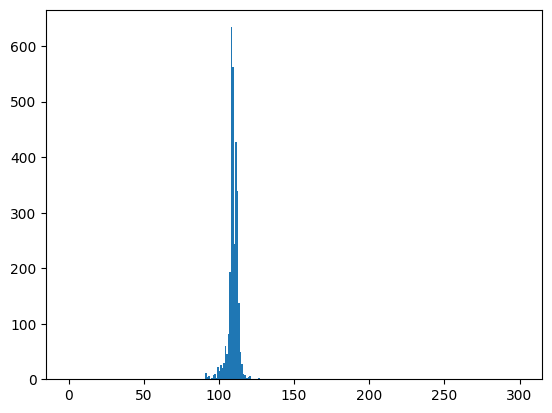

In [23]:
plt.hist(samples[:, 0], range=[0, len(data)], bins=300)
plt.show()

Histogram showing the frequency of T1 at different points during the dataset

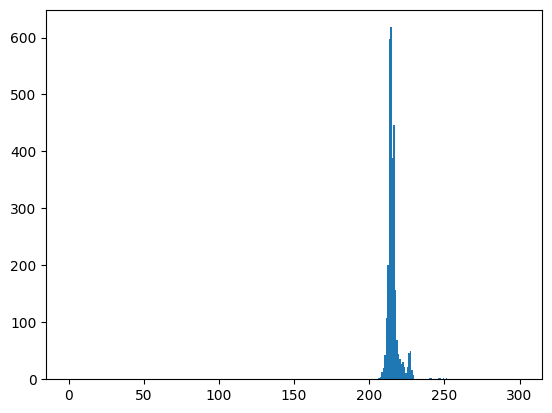

In [24]:
plt.hist(samples[:, 1], range=[0, len(data)], bins=300)
plt.show()

Histogram showing the frequency of the various probabilities for the first coin, given T0 and T1

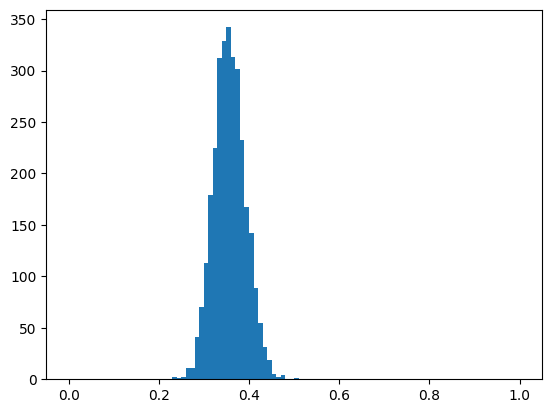

In [25]:
plt.hist(samples[:, 2], range=[0.00, 1.00], bins=100)
plt.show()

Histogram showing the frequency of the various probabilities for the second coin, given T0 and T1

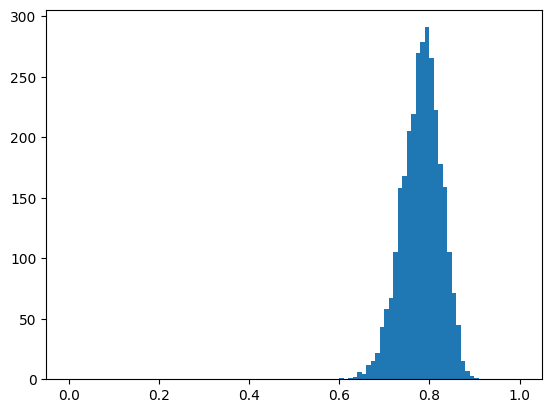

In [26]:
plt.hist(samples[:, 3], range=[0.0, 1.0], bins=100)
plt.show()

In [64]:
dataMissing = []
with open('q3_data-missing-values.txt', 'r') as file:
    dataMissing = [line.rstrip() for line in file] # getting rid of newline chars 
dataMissing = list(dataMissing)


In [66]:
samples = GibbsSampler(dataMissing)

Initial guess at t0 =  100
Initial guess at t1 =  200
Initial guess at p1 =  0.4
Initial guess at p2 =  0.74

-------------------------------------------------

T0 =  109.0
T1 =  215.0
P1 =  0.36
P2 =  0.77
